## initialisation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy import stats
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn import cluster, metrics
import matplotlib.backends.backend_pdf
from time import sleep
from tqdm.notebook import trange, tqdm
import glob
import os
import re
import collections
from sklearn import manifold, decomposition
from random import randint
from scipy.cluster.hierarchy import fcluster
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import scipy.sparse

from nltk.stem import PorterStemmer

from string import punctuation


In [2]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

colors_list = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3']

# Stopwords
stpwd = list(set(
    stopwords.words('english')))

# ajouter la ponctuation aux stopwords / caractères spéciaux
pnct = set(punctuation)
stpwd.extend(pnct)

## Fonctions

In [3]:
def colorlist(n):
    color = []

    for i in range(n):
        color.append('#%06X' % randint(0, 0xFFFFFF))
    return(color)

In [4]:
def pca_tsne(mat_inp, df_input, col_labels, nb_labels, colors_list, name="" ,niter=3000, ppxt=30, seuil=95):
    '''
    Fonction de réduction de dimensions par une PCA puis TSNE; un K-means est réalisé sur la matrice 2D du TSNE
    + visualisation des classes et des clusters.
    Paramètres :
    - mat_inp : Matrice / données en entrée
    - df_input : Données d'origines utilisées pour récupérer l'index + les labels
    - col_labels : Colonne de df_input qui contient les classes réelles
    - nb_labels : Nombre de classes
    - niter, ppxt : Nombre d'itérations et perplexité pour le t-SNE
    - seuil : cut-off pour la PCA (par défaut les var. sélectionnées expliquent 95% de la variance)
    '''
    if scipy.sparse.issparse(mat_inp):
        mat = pd.DataFrame(mat_inp.todense())
    else: mat = pd.DataFrame(mat_inp)

    dfpca, dims = fct_pca(mat)
    
    print(dfpca.shape[1]," dimensions avant pca")

    for i in range(0, len(dims), 1):
        if sum(dims[0:i]) >= seuil:
            dfpca = dfpca.iloc[:, 0:i]
            print(i, 'dimensions après pca')
            break

    tsne = manifold.TSNE(n_components=2,
                         perplexity=ppxt,
                         n_iter=niter,
                         init='random',
                         learning_rate=100,
                         random_state=42)

    X_tsne = tsne.fit_transform(dfpca)

    cls = cluster.KMeans(n_clusters=nb_labels, n_init=300, random_state=42)
    cls.fit(X_tsne)

    df_transdata = pd.DataFrame(X_tsne, index=df_input.index)
    df_transdata = df_transdata.merge(df_input[col_labels],
                                      left_index=True,
                                      right_index=True)
    

    df_transdata['labels_pred'] = cls.labels_

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(
        x=df_transdata[0],
        y=df_transdata[1],
        hue=df_transdata["labels_pred"],
        palette=colors_list,
        legend="brief",
        edgecolor='k',
        alpha=0.6)

    
    plt.title("Visualisation des clusters avec t-SNE", fontsize=15)
    plt.savefig(name+"_TSNE_clusters.png", bbox_inches='tight')

    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.scatterplot(
        x=df_transdata[0],
        y=df_transdata[1],
        hue=df_transdata["labels"],
        palette=colors_list,
        legend="brief",
        edgecolor='k',
        alpha=0.6)

    
    plt.title("Visualisation des vraies classes avec t-SNE", fontsize=15)
    plt.savefig(name+"_TSNE_vraiesclasses.png", bbox_inches='tight')
    plt.show()
    
    plt.close('all')
    ari=np.round(
            metrics.adjusted_rand_score(df_transdata.labels,
                                        df_transdata.labels_pred), 4)
    print("ARI:",ari)
    return(ari)

In [5]:
def fct_pca(matrix):

    x_prenorm = matrix

    # Normalisation
    scaler = RobustScaler()
    x = scaler.fit_transform(x_prenorm)
 #   x = np.log2(x+1)

    data_norm = pd.DataFrame(x)
    pca_test = PCA()
    principalComponents_test = pca_test.fit_transform(x)  #ndarray

    principal_test_Df = pd.DataFrame(data=principalComponents_test)

    return (principal_test_Df, pca_test.explained_variance_ratio_ * 100)

In [6]:
def tokenize(inputStr):
    token = nltk.word_tokenize(inputStr)
    filtre = [w for w in token if not w in stpwd]  # filtre stopwords
    filtre2 = [w for w in filtre if len(w) > 2]  # filtre longueur de mots
    return (filtre2)

def lemmatize(inputStr):
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in inputStr]
    return (lem_w)

def porterStem(inputStr):
    stemmer=PorterStemmer()
    stem_w=[stemmer.stem(w) for w in inputStr]
    return (stem_w)

def process_str(inputStr, stpwd, NAME=False):
    '''
    Fonction qui nettoie et normalise une chaîne de caractères. Première étape : gestion des caractères
    spéciaux et suppression des nombres (pour ne garder que les mots).
    Deuxième étape : tokenization (séparation des mots) et filtre des stopwords et mots trop cours
    Troisième étape : lemmization (forme canonique des mots)
    '''
    inputStr = inputStr.lower()
    inputStr = re.sub(r'\W', ' ', inputStr)
    inputStr = re.sub(r'\b[0-9]+\b', '', inputStr)
    token = tokenize(inputStr)
    #     print(token)
    lem_w = lemmatize(token)

    poslist = ['NN', 'NNS', 'VB', 'VBP']
    # Liste des types de mots sélectionnés. Noms (singuliers et pluriels) et verbes

    if NAME:
        pos_tagged = nltk.pos_tag(lem_w)
        coin = list(
            filter(lambda x: poslist.count(x[1]) > 0, pos_tagged))
        #         print(pos_tagged )

        lem_w = list(zip(*coin))[0]

    return (lem_w)

# Analyse
## Chargement des données, taux de remplissage et tests de la fonction  de processing

In [7]:
path_out="TextAnalysis_Figures/"
if not os.path.exists(path_out):
        os.makedirs(path_out)

arilist=[]
df_input=pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv", sep=',')
df_input.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Test traitement des phrases:

In [8]:
test = "There is a big, chunky orange cat walking all over my keyboard and i am making typos because of him; and the quick brown fox jumps over the lazy dog"
process_str(test, stpwd, NAME=True)

('chunky', 'orange', 'cat', 'keyboard', 'brown', 'jump', 'lazy', 'dog')

In [9]:
df_input['description'][1000]

'Key Features of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen  - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages'

In [10]:
test=df_input['description'][1000]
', '.join(process_str(test, stpwd, NAME=True))

'feature, lock, lock, kitchen, polypropylene, multi, storage, container, pack, lock, lock, kitchen, polypropylene, multi, storage, container, pack, price, silicone, seal, precision, hinge, closing, movement, fridge, freezer, specification, lock, lock, kitchen, polypropylene, multi, storage, container, pack, brand, lock, lock, model, number, hpl806x2, hpl836, model, name, material, polypropylene, capacity, container, type, multi, storage, container, color, box, sale, package, container, pack, warranty, manufacturing, warranty, year, warranty, manufacturing, warranty, service, type, customer, care, damage'

### Remplissage des colonnes

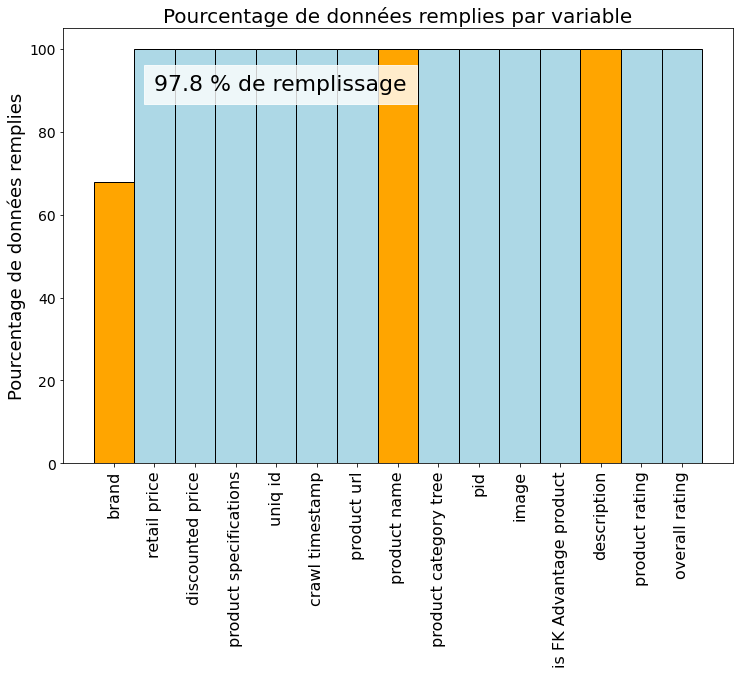

97.83492063492064


In [11]:
variables = df_input.columns.tolist()

remplissage_ini = []

# Variables à mettre en avant (orange)
tokeep = ['description', 'product name', 'brand']

# % pour chaque variable
for col in variables:
    remplissage_ini.append(100 - (df_input[col].isnull().sum() / len(df_input) * 100))

# Création dataframe + tri
df_remplissage_ini = pd.DataFrame(remplissage_ini, variables, columns=['val'])
df_remplissage_ini.sort_values(by=['val'], inplace=True)
df_remplissage_ini.index = df_remplissage_ini.index.str.replace('_', ' ')

my_pal = {
    variable: "orange" if variable in tokeep else "lightblue"
    for variable in df_remplissage_ini.index.tolist()
}

total = df_remplissage_ini['val'].sum() / len(df_remplissage_ini.index.tolist())

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(df_remplissage_ini.index.tolist(),
        df_remplissage_ini['val'],
        color=my_pal.values(),
        edgecolor='black',
        width=1)
plt.xticks(rotation='vertical', size=16)
plt.yticks(size=14)
plt.text(1,
         90,
         str(round(total, 1)) + " % de remplissage",
         fontsize=22,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='white', pad=10.0))
plt.ylabel('Pourcentage de données remplies', size=18)
plt.title('Pourcentage de données remplies par variable', size=20)
plt.savefig(path_out+"remplissagecolonnes.png", bbox_inches='tight')
plt.show()

print(total)

## Traitement du texte

### Catégories / labels :

La colonne "product_category_tree" nous permet de séparer les différents niveaux de classification des produits.

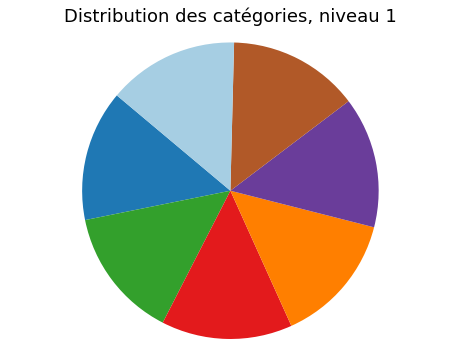

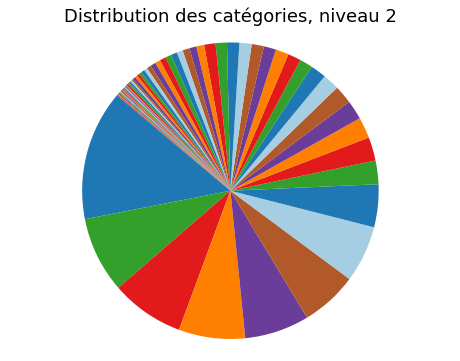

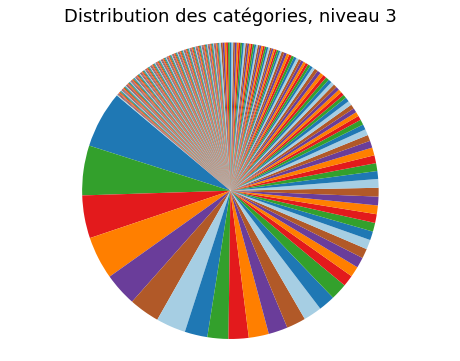

In [12]:
# Répartition des 3 premiers niveaux de classification
for level in [0,1,2]:
    lb=[]

    for i in df_input.index:
        k=df_input.at[i,'product_category_tree']
        a=k.split(' >> ')

        if len(a)>level:
            b=a[level].strip(']').strip("\"").strip('...')

            clean_desc=process_str(b, stpwd) 

            lb.append(clean_desc)
            df_input.at[i, 'labels'] = ' '.join(clean_desc)

    df_input[['uniq_id','labels']].to_csv(r'table_id.csv')

    value_counts = df_input['labels'].value_counts()

    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, startangle=140, colors=colors_list)
    plt.title('Distribution des catégories, niveau '+str(level+1), size=18)
    plt.axis('equal') 
    plt.show()

Le premier niveau possède 7 classes réparties uniformément avec assez d'échantillons pour travailler.

Les niveaux 2 et 3 ont beaucoup de catégories très peu représentées. 

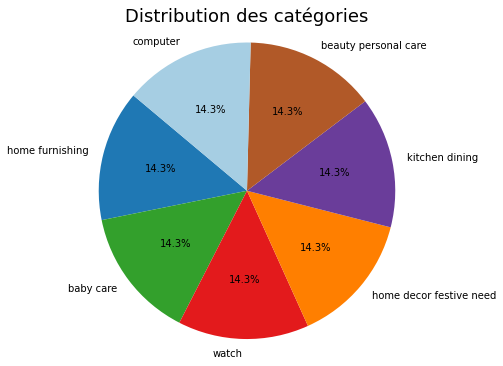

In [13]:
lb=[]

for i in df_input.index:
    k=df_input.at[i,'product_category_tree']
    a=k.split(' >> ')

    b=a[0].strip(']').strip("\"").strip('...')
    
    clean_desc=process_str(b, stpwd) 
    
    lb.append(clean_desc)
    df_input.at[i, 'labels'] = ' '.join(clean_desc)
    
df_input[['uniq_id','labels']].to_csv(r'table_id.csv')

value_counts = df_input['labels'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=colors_list)
plt.title('Distribution des catégories', size=18)
plt.axis('equal') 
plt.savefig(path_out+"distributions.png")
plt.show()

### Traitement des descriptions :

In [14]:
df_input["tokens"] = ''
all_tokens = []

for ndx in df_input.index:
    desc = df_input.loc[ndx, "description"]
    clean_token = list(set(process_str(desc, stpwd, NAME=True)))
#NAME=True pour dire qu'on ne garde que les noms+verbes

    all_tokens.append(clean_token)
    df_input.at[ndx, "tokens"] = ' '.join(clean_token)

 ### Fréquence des mots : 
 Les mots les plus présents ne sont pas représentatifs de leur catégorie / sont trop généraux. Ceux qui ne sont présent que peu de fois non plus. On peut les ignorer.

Cutoff : Mots présents moins de 10 fois et plus de 450 fois

In [15]:
a=[]
for el in all_tokens:
    a=a+el

count=collections.Counter(a)
count_sort1=dict(sorted(count.items(), key=lambda x:x[1]))

count_sort={}

for c in count_sort1:
    if count_sort1[c]>100: # sélection des mots présents + de 100 fois 
        count_sort[c]=count_sort1[c]
    

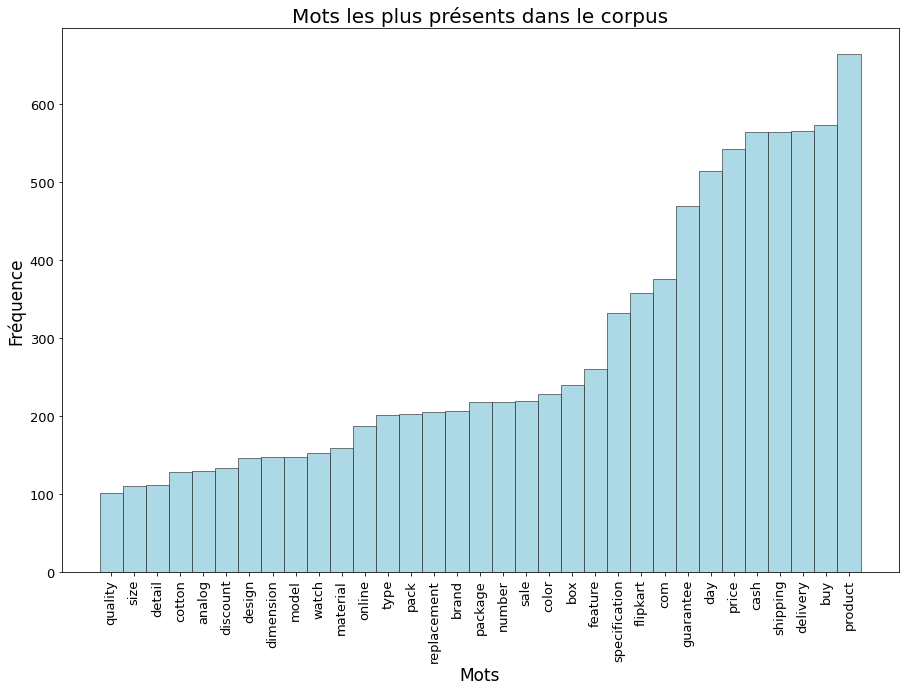

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.bar(x=count_sort.keys(),
        height=count_sort.values(),
        color='lightblue',
        edgecolor='k',
        linewidth=0.5,
        width=1)
plt.title("Mots les plus présents dans le corpus", size=20)
plt.xlabel("Mots",size=17)
plt.ylabel("Fréquence", size=17)
plt.xticks(rotation="vertical",size=13)
plt.yticks(size=13)
plt.savefig(path_out+"MostFrequentWords.png")
plt.show()

In [17]:
count_sort={} # dict de mots à ajouter aux stopwords
for c in count_sort1:
    if (count_sort1[c]<=10) | (count_sort1[c]>=450):
        count_sort[c]=count_sort1[c]

In [18]:
print("Nombre de stopwords :", len(stpwd))
keys=list(count_sort.keys())
stpwd2=set(stpwd+keys)
print("Nombre de stopwords après ajout des mots les + fréquents: ",len(stpwd2))

Nombre de stopwords : 211
Nombre de stopwords après ajout des mots les + fréquents:  2968


In [19]:
### Tokenisation des noms de produits
df_input['clean_names']=''
lb=[]

for i in df_input.index:
    k=df_input.at[i,'product_name']

    b=k.strip(']').strip("\"").strip('...')
    b=' '.join(s for s in b.split() if not any(c.isdigit() for c in s))
    clean_desc=process_str(b, stpwd, NAME=True)
    lb.append(clean_desc)

    df_input.at[i, 'clean_names'] = ' '.join(clean_desc)
    


In [20]:
df_input.clean_names

0       elegance polyester multicolor eyelet door curtain
1                                       cotton bath towel
2                             cotton terry face towel set
3                                 fashion cotton bedsheet
4                       jaipur print cotton king bedsheet
                              ...                        
1045                            oren empower self sticker
1046                                vinyl sticker sticker
1047                               polyvinyl film sticker
1048                         medium vinyl sticker sticker
1049                                        vinyl sticker
Name: clean_names, Length: 1050, dtype: object

In [21]:
# tokenisation mais avec les stop-words enrichis

df_input["tokens"] = ''
all_tokens = []

for ndx in df_input.index:
    desc = df_input.loc[ndx, "description"]
    clean_token = list(set(process_str(desc, stpwd2, NAME=True)))
    #clean_token = list(process_str(desc, stpwd, NAME=True))

    all_tokens.append(clean_token)
    df_input.at[ndx, "tokens"] = ' '.join(clean_token)

df_input["name_desc"]=df_input['tokens']+" "+df_input['clean_names']

# Approches de type Bag of Words

- name_desc => nom et description des produits
- tokens => description des produits
- clean_names => noms des produits

Les algorithmes testés ci-dessous sont calibrés sur "clean_names" (On considère que les noms de produit sont très significatifs de leur fonction / catégorie)

Les features sont extraites et les clusters calculés sur "name_desc" qui comporte le nom du produit et sa description

In [22]:
#colors_list=colorlist(df_input['labels'].nunique())

VAR_FIT=df_input["clean_names"] 
VAR_TRANSFORM=df_input["name_desc"]
NB_LABELS=df_input['labels'].nunique()


## Comptage simple

1050  dimensions avant pca
418 dimensions après pca


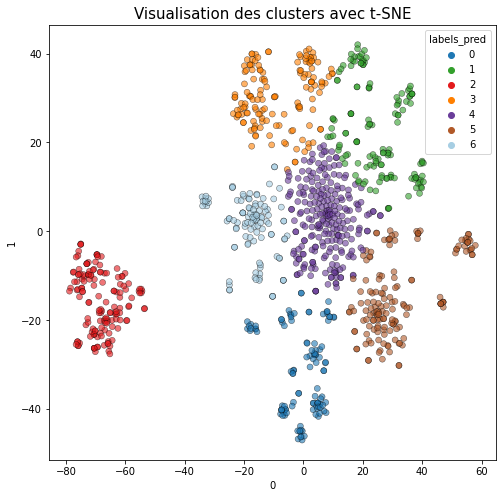

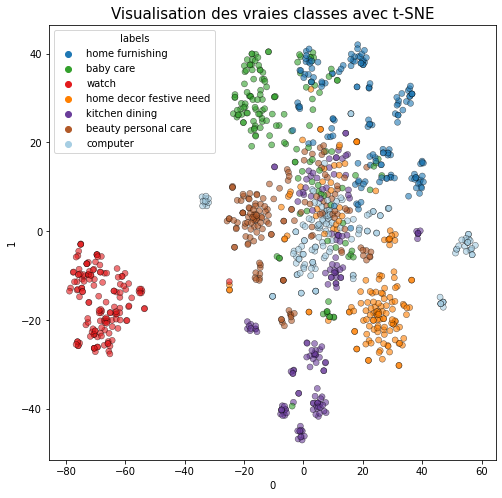

ARI: 0.4631


In [23]:
cvect = CountVectorizer(stop_words=stpwd, max_df=150, min_df=0)
cv_fit = cvect.fit(VAR_FIT)
cv_transform = cvect.transform(VAR_TRANSFORM)
    
tmp=pca_tsne(cv_transform, df_input, 'labels', NB_LABELS, colors_list, name=path_out+"countVect",
         niter=5000, ppxt=30, seuil=94)
arilist.append(["countvectorize",tmp])

## TF-IDF

242  dimensions avant pca
176 dimensions après pca


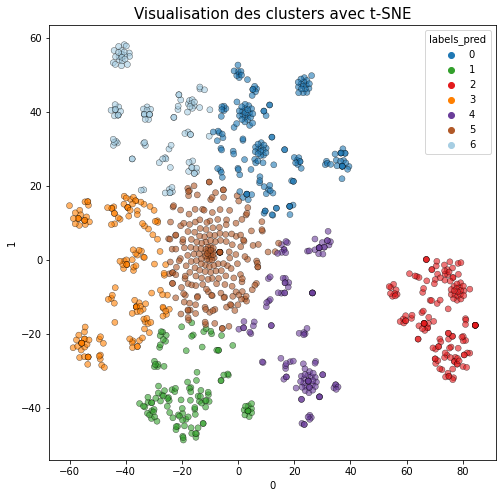

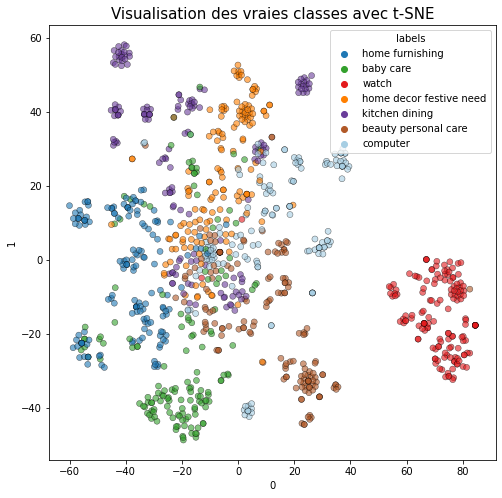

ARI: 0.4334


In [24]:
ctf = TfidfVectorizer(stop_words=stpwd2, max_df=0.95, min_df=1)
ctf_fit = ctf.fit(VAR_FIT)
ctf_transform = ctf.transform(VAR_TRANSFORM)

tmp=pca_tsne(ctf_transform, df_input, 'labels', NB_LABELS, colors_list, name=path_out+'tfidf', niter=5000, ppxt=30, seuil=98)
arilist.append(["TFIDF",tmp])

# Modèles d'embedding

## Word2Vec

In [25]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

2023-08-15 18:24:28.674718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 18:24:28.775004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-15 18:24:28.775016: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-15 18:24:29.344783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [26]:
INPUT='name_desc'

# Get max length of sentences
maxi=0
for lab in df_input[INPUT]:
    if len(lab.split(' '))>maxi: maxi=len(lab.split(' '))
print(maxi)

112


In [27]:
w2v_size=200
w2v_window=5
w2v_min_count=5
w2v_epochs=100

maxlen = maxi # adapt to length of sentences
sentences = df_input[INPUT].to_list() 
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]


In [28]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                               workers=multiprocessing.cpu_count())



Build & train Word2Vec model ...


In [29]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)

model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 700
Word2Vec trained


In [30]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
# tokenizer.fit_on_texts(sentences)
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 3049


In [31]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j / i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.2297
Embedding matrix: (3049, 200)


In [32]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen, ), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112)]             0         
                                                                 
 embedding (Embedding)       (None, 112, 200)          609800    
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 609,800
Trainable params: 609,800
Non-trainable params: 0
_________________________________________________________________


2023-08-15 18:24:32.224963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-15 18:24:32.224981: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-15 18:24:32.224996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (camille-NL40-50CU): /proc/driver/nvidia/version does not exist
2023-08-15 18:24:32.225194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


33/33 [==============================] - 0s 1ms/step
(1050, 200)
200  dimensions avant pca
22 dimensions après pca


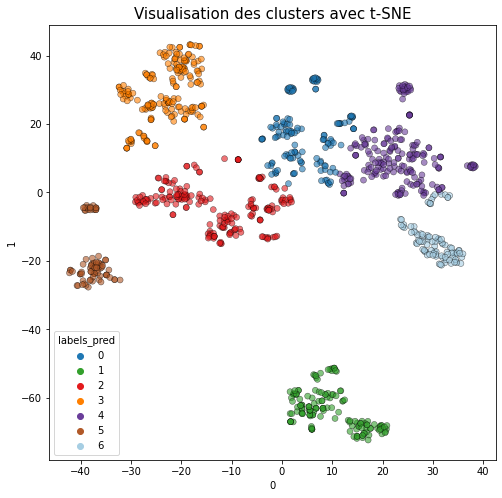

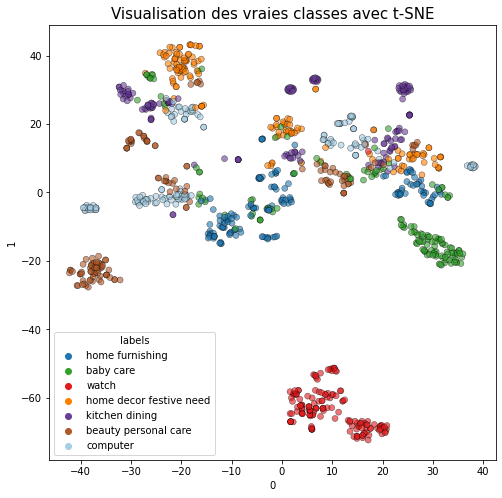

ARI: 0.2996


0.2996

In [33]:
embeddings = embed_model.predict(x_sentences)
print(embeddings.shape)

tmp=pca_tsne(embeddings, df_input, 'labels', NB_LABELS, colors_list, name=path_out+"w2v",
         niter=3000, ppxt=30, seuil=96)
arilist.append(["w2v",tmp])
tmp

## Modèle BERT

In [34]:
import tensorflow as tf
# import tensorflow_hub as hub

import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *
import time

os.environ["TF_KERAS"]='1'

/home/camille/.local/lib/python3.10/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [35]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  0
True


In [36]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [37]:
max_length = 64 
batch_size = 10 # qqté de données utilisée pour apprentissage - tester en multiple de 2
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_input['name_desc'].to_list()

loading configuration file config.json from cache at /home/camille/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /home/camille/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076

In [38]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /home/camille/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /home/camille/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/vocab.txt

1/1 [==============================] - 1s 710ms/step
temps traitement :  79.0


768  dimensions avant pca
129 dimensions après pca


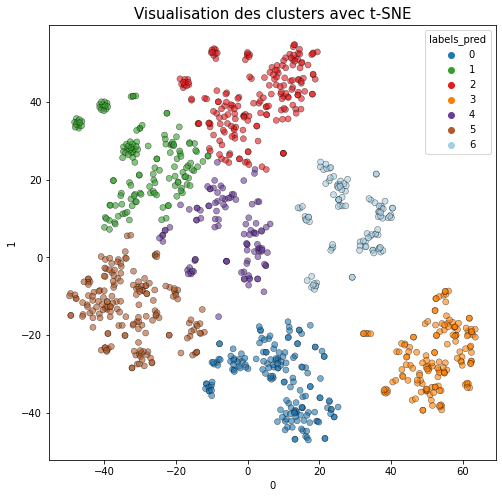

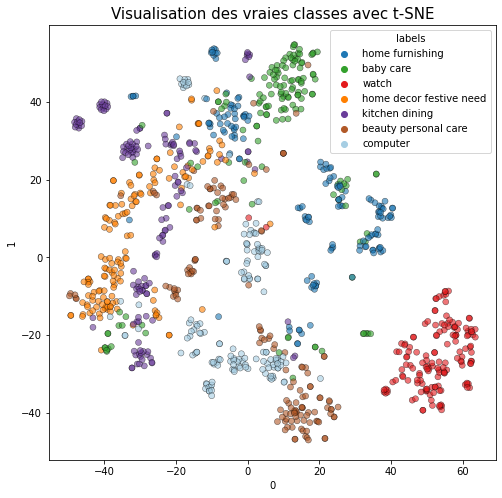

ARI: 0.3796


In [39]:

tmp=pca_tsne(features_bert, df_input, 'labels', NB_LABELS, colors_list, name=path_out+'bert',
         niter=2000, ppxt=20, seuil=94)
arilist.append(["bert",tmp])

## USE - Universal Sentence Embedding

In [40]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [41]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  0
True


In [42]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [43]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [44]:
batch_size = 10
sentences = df_input['name_desc'].to_list()

In [45]:
features_USE = feature_USE_fct(sentences, batch_size)

512  dimensions avant pca
116 dimensions après pca


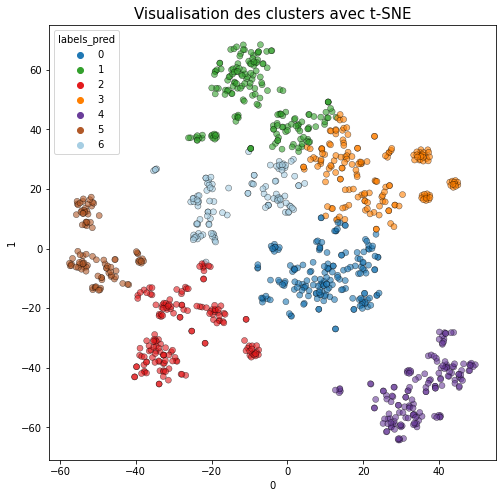

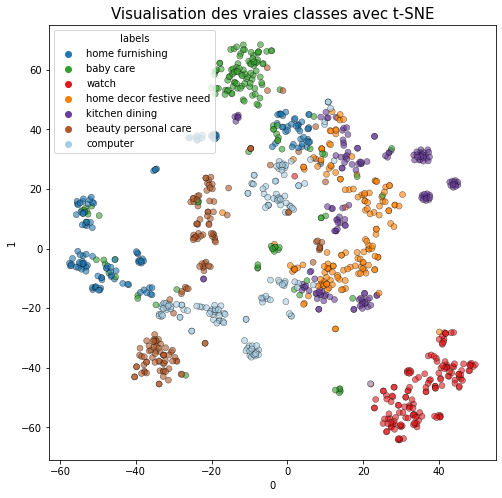

ARI: 0.41
0.41


In [46]:
tmp=pca_tsne(features_USE, df_input, 'labels', NB_LABELS, colors_list, name=path_out+'USE',
         niter=2000, ppxt=20, seuil=90)
arilist.append(["USE",tmp])
print(tmp)

In [47]:
arilist

[['countvectorize', 0.4631],
 ['TFIDF', 0.4334],
 ['w2v', 0.2996],
 ['bert', 0.3796],
 ['USE', 0.41]]

In [48]:
pd.DataFrame(arilist,columns=["Method","ARI"]).to_csv(r"ARI_wordPrecessing.csv")